<a href="https://colab.research.google.com/github/kovzanok/ml/blob/main/hw_01_logistic_regression_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Логистическая регрессия для классификации текста
В этом домашнем задании вам предстоит решить каноническую задачу классификации текста --- создать спам-фильтр. Задание большей частью вам придется решать самостоятельно. Для этого можно использовать методы, которые мы проходили на семинаре.

## Данные и посылка
Как и во многих следующих домашних заданиях курса, в этом задании мы будем проверять и оценивать вашу посылку так, как это происходит на конкурсах по машинному обучению (например, на платформе kaggle.com). Для этого мы предварительно разделили данные в задании на две части.

* `data_train.csv`. В каждой строчке файла `data_train.csv` указан текст, который необходимо классифицировать, (столбец `Message`) и целевая переменная (столбец `Category`), принимающая 2 значения: "spam" и "ham", где spam --- это спамовое сообщение, а ham --- просто sms-ка. На этом наборе данных вам необходимо создать и обучить модель.
* `data_scoring.csv`. В каждой строчке файла `data_scoring.csv` указан текст, который необходимо классифицировать, используя обученную модель. Полученные предсказания необходимо записать в файл `submission.csv` и сдать в соответствующий шаг на Stepik. Количество попыток ограничено 100 штук.

Также мы предоставляем файл [`sample_submission.csv`](https://drive.google.com/file/d/1uGPbOSiZx0S9dTdQnam16ncXE6w0JvFm/view?usp=share_link). Это образец посылки --- ваш файл `submission.csv` должен быть оформлен таким же образом.

## Целевая метрика и выставление баллов
Целевая метрика в этой задаче --- ROC-AUC. Именно по ней система будет выставлять вам баллы. Минимальное значение ROC-AUC, за которое ставятся баллы, равно $lb=0.90$. Чтобы набрать полный балл за задание, необходимо набрать $ub=0.99$.
Оценка выставляется по формуле
$$\begin{cases}
0, & score \leqslant lb,\\
10 \cdot \frac{score - lb}{ub - lb}, & lb < score < ub,\\
10, & score \geqslant ub.
\end{cases}$$

Обратите внимание: авторы курса не гарантируют, что качество $0.99$ можно получить методами с семинара. Наше решение дает качество 0.974, но скорее всего аккуратным перебором гиперпараметров можно получить баллы выше.

## Ход работы
Мы предлагаем следующий пайплайн работы.
* Загрузка и обработка данных `data_train.csv`. Часть этой загрузки мы сделали за вас. На этом этапе рекомендуем воспользоваться схемой из семинара.
* Обучение первого варианта модели. Выберите любую модель, которую мы рассматривали на семинаре, и посмотрите, какое качество она дает на наших данных (для этого внутри этого пункта выделите небольшую тестовую выборку, в следующих пунктах она вам не пригодится, так как там мы будем использовать кросс-валидацию).
* Написание пайплайна тестирования. Специфика данных состоит в том, что размер `data_train` мал по сравнению с размером `data_scoring`. Поэтому разделять данные в `data_train` на обучающее и тестирующее множество жалко. По этой причине мы рекомендуем вам воспользоваться процедурой кросс-валидации для более надеждного измерения качества модели. Вам поможет `sklearn.model_selection.cross_validate`.
* Обратите внимание, что если при кросс-валидации кодировать с помощью Bag of Words данные на всем обучающем множестве $X$, то это повлечет переобучение (поскольку, например, модель, обученная на фолдах №1, №2, №3, №4, будет иметь информацию о словах, которые встречались в текстах фолда №5, но не будет иметь информацию о словах из `data_scoring`). Поэтому мы рекомендуем вам реализовать кросс-валидацию вручную, для каждого фолда обучая свой Bag Of Words: тогда качество на каждом фолде будет "честным". Для того, чтобы реализовать кросс-валидацию вручную, можно использовать [`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).
Впрочем, хорошие результаты получаются и при использовании стандартной кросс-валидации (но качество на `data_scoring` при сдаче в систему в таком случае может немного упасть).
* Загрузка данных из `data_scoring.csv`, применение модели и создание `submission.csv`. **Обязательно проверьте, что формат файла совпадает с форматом `sample_submission.csv`!**

Желаем удачи!

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
%matplotlib inline

## Загрузка данных

In [2]:
!gdown 1yacgNpDCFREwRe0qiOpTyoik2Jz_z-fu  # data_train.csv
!gdown 1yt9p3Syey65CnNJugcFZsNrOGELBd3LS  # data_scoring.csv

Downloading...
From: https://drive.google.com/uc?id=1yacgNpDCFREwRe0qiOpTyoik2Jz_z-fu
To: /content/data_train.csv
100% 34.7k/34.7k [00:00<00:00, 27.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yt9p3Syey65CnNJugcFZsNrOGELBd3LS
To: /content/data_scoring.csv
100% 424k/424k [00:00<00:00, 47.8MB/s]


In [3]:
data = pd.read_csv('data_train.csv')
data.head()

,Category,Message
0,ham,TODAY is Sorry day.! If ever i was angry with ...
1,ham,I.ll give her once i have it. Plus she said gr...
2,ham,Where is it. Is there any opening for mca.
3,ham,K:)k:)what are detail you want to transfer?acc...
4,ham,"Wen ur lovable bcums angry wid u, dnt take it ..."


<Axes: >

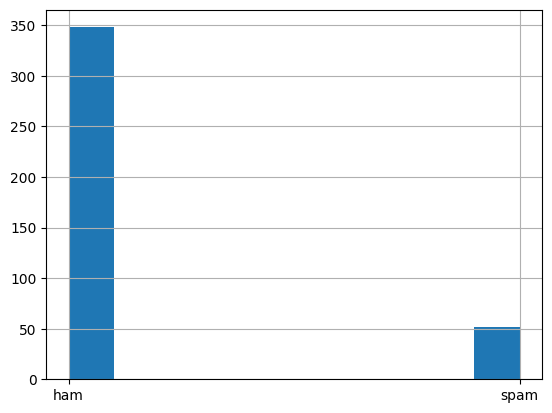

In [4]:
data['Category'].hist()

**Задание**. Обработайте данные: выделите целевую переменную, произведите лемматизацию (по желанию).

In [5]:
encoder = LabelEncoder()

encoded_labels = encoder.fit_transform(data['Category'])
data['y'] = encoded_labels

In [8]:
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize


tokens = [list(filter(lambda s:s.isalpha(), word_tokenize(text.lower()))) for text in data['Message'].to_list()]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

text = []

for text_tokens in tokens:
    lemmatized_message = []
    for word in text_tokens:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_message.append(word)
    text.append(' '.join(lemmatized_message))

In [10]:
data['x'] = text

In [11]:
data.head()

,Category,Message,y,x
0,ham,TODAY is Sorry day.! If ever i was angry with ...,0,today is sorry if ever i was angry with you if...
1,ham,I.ll give her once i have it. Plus she said gr...,0,give her once i have it plus she said grinule ...
2,ham,Where is it. Is there any opening for mca.,0,where is it is there any opening for mca
3,ham,K:)k:)what are detail you want to transfer?acc...,0,k k what are detail you want to transfer acc n...
4,ham,"Wen ur lovable bcums angry wid u, dnt take it ...",0,wen ur lovable bcums angry wid u dnt take it s...


## Обучение первого варианта модели
**Задание.** Выделите (только для этого пункта) из data_train тестовую часть. Обучите какую-то из моделей, которые мы использовали на семинаре, и посчитайте качество на тестовых данных.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], train_size=0.8)

In [13]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

vectorizer = CountVectorizer(stop_words=list(stop_words))
vectorizer.fit(X_train)

vocabulary = vectorizer.get_feature_names_out()
description_count = vectorizer.transform(X_train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def get_top_k_words(vocabulary, description_count, k = 10):
    top_k = sorted(zip(vocabulary, description_count.sum(axis=0).getA1()), key=lambda tup:tup[1], reverse=True)[:k]
    return ', '.join([word for word, _ in top_k])

In [15]:
get_top_k_words(vocabulary, description_count)

'call, get, ur, love, ok, lt, gt, text, come, day'

In [16]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

0.7352941176470588


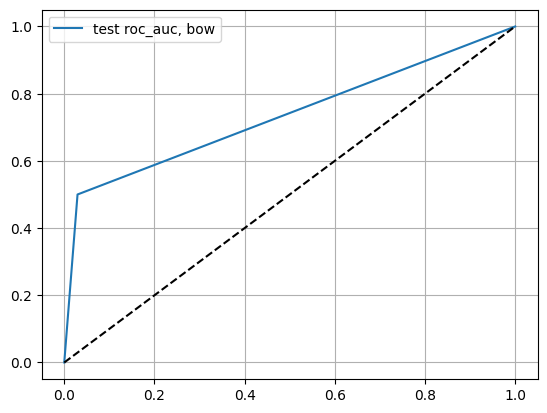

In [19]:
plt.plot(*roc_curve(y_test,y_pred)[:2], label = 'test roc_auc, bow')

plt.plot([0,1],[0,1],'--', color='black')
plt.grid()
plt.legend()

print(roc_auc_score(y_test, y_pred))

## Написание пайплайна тестирования
Задание. Напишите схему кросс-валидации, которая будет тестировать качество модели с данными параметрами.

In [20]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tokens = [list(filter(lambda s:s.isalpha(), word_tokenize(text.lower()))) for text in X]
        lemmatized_text = [ ' '.join([ self.lemmatizer.lemmatize(word) for word in token_list ]) for token_list in tokens ]

        return lemmatized_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
def run_model_pipeline(steps: list[BaseEstimator], X, y, model_name):
    model = make_pipeline(NLTKPreprocessor(),*steps)
    scores = cross_validate(model, X, y, scoring=['roc_auc'])
    plot_roc_curve(model, X, y, model_name)

    return np.mean(scores['test_roc_auc'])

def plot_roc_curve(model, X, y, model_name):
    y_prob = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

    # ROC-кривая
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    auc = roc_auc_score(y, y_prob)

    # Визуализация
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## Выбор лучшей модели
Протестируйте с помощью написанного пайплайна несколько моделей, которые мы рассматривали на семинаре. Выберите ту из них, которая дает лучшее среднее качество на кросс-валидации.

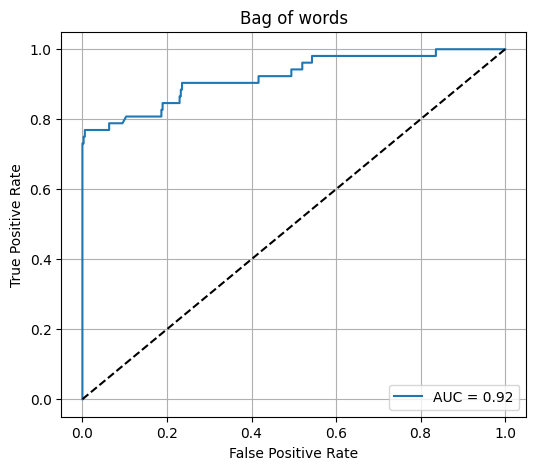

0.9231033314511574


In [22]:
score = run_model_pipeline([CountVectorizer(stop_words=list(stop_words)),
                             MultinomialNB()],
                            X=data['x'],
                            y=data['y'],
                           model_name='Bag of words')
print(score)

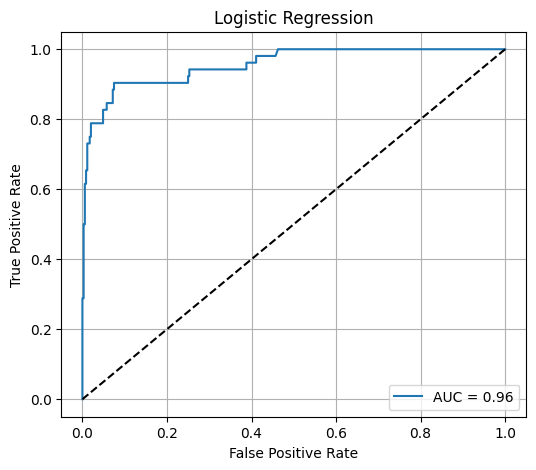

0.9565198569546396


In [23]:
score = run_model_pipeline([CountVectorizer(stop_words=list(stop_words)),
                            LogisticRegression()],
                            X=data['x'],
                            y=data['y'],
                           model_name='Logistic Regression')
print(score)

In [164]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0

In [49]:
import gensim.downloader

class EmbeddingPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, embeddings):
        self.embeddings = embeddings

    def fit(self, X, y=None):
        return self

    def _vectorize_sum(self, comment):
        embedding_dim = self.embeddings.vectors.shape[1]

        try:
            comment_vectors = np.stack([ self.embeddings.get_vector (word) if word in self.embeddings else np.zeros(embedding_dim) for word in comment.split() ])
        except:
            print('no vector created')
            comment_vectors = np.zeros((1, embedding_dim))

        features = np.sum(comment_vectors, axis=0)
        return features

    def transform(self, X):
        X_wv = np.stack([self._vectorize_sum(text) for text in X])

        return X_wv

In [45]:
embs = gensim.downloader.load('glove-wiki-gigaword-100')

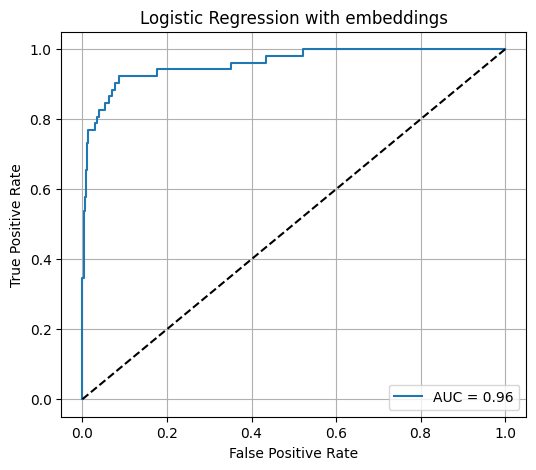

0.9641543384152079


In [54]:
score = run_model_pipeline([EmbeddingPreprocessor(embeddings=embs),
                            LogisticRegression(max_iter=1000)],
                            X=data['x'],
                            y=data['y'],
                           model_name='Logistic Regression with embeddings')
print(score)

## Обучение финальной модели
После выбора лучшей модели, обучите ее на всех доступных данных (`data_train`).

In [56]:
best_model = make_pipeline(NLTKPreprocessor(),
                      EmbeddingPreprocessor(embeddings=embs),
                      LogisticRegression(max_iter=1000))

best_model.fit(data['x'], data['y'])

Pipeline(steps=[('nltkpreprocessor', NLTKPreprocessor()),
                ('embeddingpreprocessor',
                 EmbeddingPreprocessor(embeddings=<gensim.models.keyedvectors.KeyedVectors object at 0x7ecaf50d98d0>)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Применение модели на data_scoring и формирование submission
Загрузите данные из `data_scoring.csv`. Обработайте их так же, как вы обработали `data_train.csv`. Примените лучшую модель и сформируйте submission. Сдайте ее на Stepik.

**Обратите внимание, что метрика, используемая в задании --- ROC-AUC. Поэтому вам необходимо предсказать не класс, а вероятность класса `spam`.**

In [57]:
data_scoring = pd.read_csv('data_scoring.csv')
data_scoring.head()

,Message
0,"Hurry up, I've been weed-deficient for like th..."
1,Sounds like a plan! Cardiff is still here and ...
2,Is it your yahoo boys that bring in the perf? ...
3,"K, I'll work something out"
4,Hi im having the most relaxing time ever! we h...


In [59]:
preds = best_model.predict_proba(data_scoring['Message'])

no vector created
no vector created
no vector created
no vector created
no vector created
no vector created


In [73]:
y_scoring = [ lst[1] for lst in preds]
# классу "spam" полученные с помощью модели на data_scoring.csv

In [74]:
pd.Series(y_scoring, name='score').to_csv('submission.csv', index=None)